In [2]:
import pandas as pd
from pathlib import Path

# Define file paths
input_path = Path(
    r"C:\Users\lebro\OneDrive\Desktop\TechM\By Symptoms dataset\oasis_longitudinal.csv")
output_path = Path(
    r"C:\Users\lebro\OneDrive\Desktop\TechM\By Symptoms dataset\cleaned_data.csv")

# Read, clean and save data
df = pd.read_csv(input_path, low_memory=False)
df = df.dropna()
df.to_csv(output_path, index=False)

In [3]:
# df.columns
# df.info
df.head(5)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039


In [4]:
import csv
import statistics
import time
import math

# Load and clean data
data = [
    [float(val) if val.replace('.', '', 1).isdigit()
     else math.nan for val in row]
    for row in csv.reader(open(r"C:\Users\lebro\OneDrive\Desktop\IDP\Disease Symptoms Dataset\cleaned_data.csv"))][1:]

# Initialization
totalObjCount, totalLen = len(data), len(data[0]) if data else 0
print(
    f'Total no. of objects = {totalObjCount}, Total no. of attributes = {totalLen}' if totalObjCount else 'No valid data found.')

# Utility functions


def truncate(n, d=0): return int(n * 10**d) / 10**d


def findSim(x, y, std): return truncate(
    max(0, min((x - y + std) / std, (y - x + std) / std)), 2)


# Main processing
if totalLen > 0:
    decisionVariable, reductOutput, posReg = [row[0] for row in data], [], 0.0
    resultFirst = [(descId, attrId) for descId in range(totalObjCount) for attrId in range(
        totalLen) if decisionVariable[descId] != decisionVariable[attrId] and descId < attrId]

    for i in range(1, totalLen - 1):
        BC_List = [row[i] for row in data]
        filtered_BC_List = [val for val in BC_List if not math.isnan(val)]
        if len(filtered_BC_List) < 2:
            continue
        std_dev = statistics.stdev(filtered_BC_List)
        if std_dev == 0:
            continue
        resultRdd = [(x[0], x[1], 1 - findSim(BC_List[x[0]],
                      BC_List[x[1]], std_dev)) for x in resultFirst]
        storeKeyVal = {key: min(1, val)
                       for key, val in [(x[0], x[2]) for x in resultRdd]}
        currPosReg1 = sum(storeKeyVal.values())
        if posReg < currPosReg1:
            reductOutput.append(i)
            posReg = currPosReg1
            resultFirst = [(x[0], x[1], 0.0, x[2]) for x in resultRdd]
        if posReg == totalObjCount:
            break

    print(f"reductOutput after forward process: {reductOutput}")

    # Backward elimination
    for i in reductOutput[:]:
        BC_List = [row[i] for row in data]
        filtered_BC_List2 = [val for val in BC_List if not math.isnan(val)]
        if len(filtered_BC_List2) < 2:
            continue
        std_dev2 = statistics.stdev(filtered_BC_List2)
        if std_dev2 == 0:
            continue
        resultRdd = [(x[0], x[1], 1 - findSim(BC_List[x[0]],
                      BC_List[x[1]], std_dev2)) for x in resultFirst]
        storeKeyVal = {key: min(1, val)
                       for key, val in [(x[0], x[2]) for x in resultRdd]}
        currPosReg1 = sum(storeKeyVal.values())
        if posReg == currPosReg1:
            reductOutput.remove(i)
            resultFirst = [(x[0], x[1], 0.0, x[2]) for x in resultRdd]

    print(f"reductOutput after backward elimination: {reductOutput}")

else:
    print("No processing done due to lack of valid attributes.")

print('Execution time:', time.time(), 'seconds')

Total no. of objects = 354, Total no. of attributes = 15
reductOutput after forward process: [3, 4, 7]
reductOutput after backward elimination: [3, 4]
Execution time: 1732148625.348532 seconds


In [5]:
# import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load, prepare, and optionally convert target to categorical
df = pd.read_csv(
    r"C:\Users\lebro\OneDrive\Desktop\IDP\Disease Symptoms Dataset\cleaned_data.csv")
X, y = df.iloc[:, [4, 7, 8, 9, 10, 11, 12, 13]], df.iloc[:, -1]
if y.dtype != 'object' and len(y.unique()) > 10:
    y = pd.cut(y, bins=3, labels=['Low', 'Medium', 'High'])

# Split, standardize, and train models
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(
    X_train), scaler.transform(X_test)  # Fit and transform

# Train KNN & SVM models
knn, svm = KNeighborsClassifier(5).fit(X_train, y_train), SVC(
    kernel='linear').fit(X_train, y_train)

# Print accuracies
print(f'KNN Accuracy: {accuracy_score(y_test, knn.predict(X_test)):.2f}')
print(f'SVM Accuracy: {accuracy_score(y_test, svm.predict(X_test)):.2f}')

KNN Accuracy: 0.82
SVM Accuracy: 0.96


In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

# Training data and preprocessing
X_train = np.array([[70, 12, 2.0, 25, 0.5, 1500, 0.75, 1.0],
                    [80, 16, 3.0, 20, 1.0, 1450, 0.65, 1.1],
                    [65, 10, 2.0, 28, 0.0, 1550, 0.80, 1.2]])
y_train = np.array(["Demented", "Nondemented", "Demented"])
scaler, label_encoder = StandardScaler().fit(
    X_train), LabelEncoder().fit(y_train)
X_scaled = scaler.transform(X_train)
model = LogisticRegression().fit(X_scaled, label_encoder.transform(y_train))

# Prediction function


def predict_alzheimer(age, mmse, cdr, model, scaler, label_encoder, educ=12, ses=2.0, etiv=1500, nwbv=0.75, asf=1.0):
    if not (60 <= age <= 100 and 0 <= mmse <= 30 and 0 <= cdr <= 3):
        raise ValueError("Invalid input values.")
    input_features = scaler.transform(
        [[age, educ, ses, mmse, cdr, etiv, nwbv, asf]])
    prediction = model.predict(input_features)
    prediction_proba = model.predict_proba(input_features)[0]
    predicted_class = label_encoder.inverse_transform(prediction)[0]
    return predicted_class, dict(zip(label_encoder.classes_, prediction_proba))

# User input and output


def get_user_input():
    return [int(input(f"Enter {param}: ")) if param != 'MMSE' and param != 'CDR' else float(input(f"Enter {param}: ")) for param in ['age', 'MMSE', 'CDR']]


# Main execution
if __name__ == "__main__":
    try:
        age, mmse, cdr = get_user_input()
        diagnosis, probs = predict_alzheimer(
            age, mmse, cdr, model, scaler, label_encoder)
        print(f"\nPredicted Diagnosis: {diagnosis}")
        print(
            f"The individual is predicted to {'have' if diagnosis == 'Demented' else 'not have'} Alzheimer's Disease.")
        print("Class Probabilities:")
        for label, prob in probs.items():
            print(f"{label}: {prob:.2f}")
    except ValueError as e:
        print(e)


Predicted Diagnosis: Demented
The individual is predicted to have Alzheimer's Disease.
Class Probabilities:
Demented: 0.70
Nondemented: 0.30


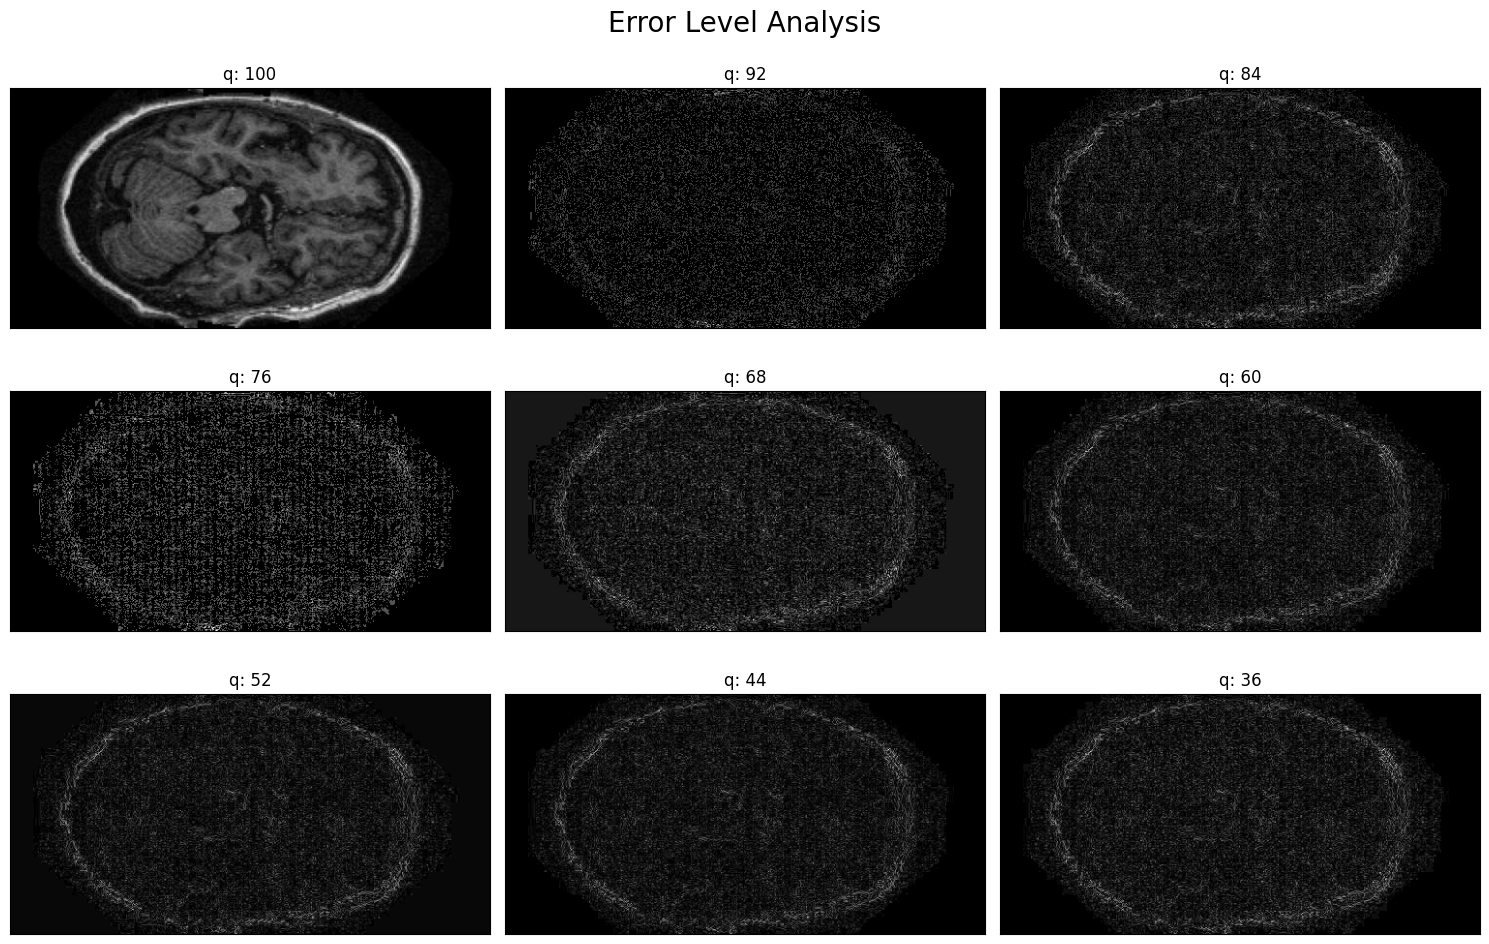

In [7]:
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path


def random_sample(path, ext=None):
    return random.choice(list(Path(path).glob(f'*.{ext}' if ext else '*'))).as_posix()


def compute_ela_cv(path, quality=90):
    img = cv2.imread(path)
    temp_path = "temp.jpg"
    cv2.imwrite(temp_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    return cv2.normalize(cv2.absdiff(img, cv2.imread(temp_path)), None, 0, 255, cv2.NORM_MINMAX)


train_image_path = r"C:\Users\lebro\OneDrive\Desktop\TechM\By scanned images\input\Mild Dementia"
p = random_sample(train_image_path)
orig = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) / 255.0

fig = plt.figure(figsize=(15, 10), dpi=100, tight_layout=True)
fig.suptitle('Error Level Analysis', fontsize=20)

for i in range(1, 10):
    quality = 100 - (i - 1) * 8
    img = compute_ela_cv(p, quality) if i > 1 else orig
    ax = fig.add_subplot(3, 3, i)
    ax.imshow(img)
    ax.set_title(f'q: {quality}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [14]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("WARNING: No GPU detected. Training will be slow.")

# Data pipeline
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

dataset_dir = r"C:\Users\lebro\OneDrive\Desktop\TechM\By scanned images\input"

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Debug single batch loading time
for x_batch, y_batch in train_generator:
    print(f"Train Batch X shape: {x_batch.shape}, Y shape: {y_batch.shape}")
    break

for x_batch, y_batch in valid_generator:
    print(
        f"Validation Batch X shape: {x_batch.shape}, Y shape: {y_batch.shape}")
    break

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=list(range(train_generator.num_classes)),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Computed Class Weights:", class_weights)

# Model
base_model = MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

# Use prefetch to improve data pipeline performance
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None, 4])
).prefetch(buffer_size=tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: valid_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None, 4])
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_dataset,
    validation_steps=validation_steps,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

# Fine-tuning the base model
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_dataset,
    validation_steps=validation_steps,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

print("Training complete!")

Num GPUs Available:  0
Found 7591 images belonging to 4 classes.
Found 1897 images belonging to 4 classes.
Train Batch X shape: (32, 224, 224, 3), Y shape: (32, 4)
Validation Batch X shape: (32, 224, 224, 3), Y shape: (32, 4)
Computed Class Weights: {0: 0.7907291666666667, 1: 4.853580562659847, 2: 0.7907291666666667, 3: 0.7907291666666667}
Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.3008 - loss: 1.3968 - val_accuracy: 0.2938 - val_loss: 1.3598 - learning_rate: 1.0000e-04
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 205s 867ms/step - accuracy: 0.4373 - loss: 1.1871 - val_accuracy: 0.3628 - val_loss: 1.2862 - learning_rate: 1.0000e-04
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 217s 918ms/step - accuracy: 0.5066 - loss: 1.0735 - val_accuracy: 0.3662 - val_loss: 1.3275 - learning_rate: 1.0000e-04
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 196s 827ms/step - accuracy: 0.5418 - loss: 1.0307 - val_accuracy: 0.4327 - val_loss: 1.2534 - learning_rate: 1.0000e-04
Epoch 5/10
237/237 ━━

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the model (ensure the path to your model is correct)
model_path = r"C:\Users\lebro\OneDrive\Desktop\TechM\By scanned images\alzheimers_model_final.keras"
model = tf.keras.models.load_model(model_path)

# If the model was not compiled before saving, compile it now
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

# Load Test Data (Resize test images to match the model's expected input size)
test_datagen = ImageDataGenerator(rescale=1./255)

# Update the dataset path for your test images
dataset_dir = r"C:\Users\lebro\OneDrive\Desktop\TechM\By scanned images\input"

# Check model's input shape
print(f"Expected input shape: {model.input_shape}")

# Resize test images to match model's input size
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  # Adjust to match your model's expected input size
    batch_size=32,
    class_mode='categorical',  # Assuming categorical labels
    shuffle=False
)

# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

Expected input shape: (None, 224, 224, 3)
Found 9488 images belonging to 4 classes.
297/297 ━━━━━━━━━━━━━━━━━━━━ 237s 792ms/step - accuracy: 0.7315 - loss: 0.7427
Test Accuracy: 0.72
Test Loss: 0.73


In [11]:
model.save('final_model.keras')  # Save the entire model

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = tf.keras.models.load_model('final_model.keras')

# Load and preprocess the new image
# Replace with the path to your new image
img_path = r'C:\Users\lebro\OneDrive\Desktop\TechM\temp.jpg'
img = image.load_img(img_path, target_size=(224, 224)
                     )  # Resize to match model input
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale the image

# Make a prediction
predictions = model.predict(img_array)

# Output the prediction
predicted_class = np.argmax(predictions, axis=1)
class_names = ['Mild Dementia', 'Moderate Dementia', 'Non Demented',
               'Very mild Dementia']  # Update this list with your class names

print(f"Predicted class: {class_names[predicted_class[0]]}")

c:\Users\lebro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
Predicted class: Non Demented
